In [1]:
from utils import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Define Priors

In [2]:
# Demonstration: Simulate priors

np.random.seed(1)

C = 20 # Number of segments

w_c = np.random.uniform(0,1, C) # Relative segment sizes (sum to 1)
w_c = w_c/np.sum(w_c)

mu_c = np.random.normal(0, 1, C) # Prior means of the treatment effects (by segment)
sigma_c = np.random.uniform(5,10,C) # Prior std dev of the treatment effects (by segment)
s_c = np.random.uniform(80,100, C) # Customer outcome variances (by segment)

# sim_priors = pd.DataFrame(np.column_stack([w_c, mu_c, sigma_c,s_c]),columns=['w_c', 'mu_c', 'sigma_c', 's_c'])
# sim_priors.to_csv("simulated_priors.csv",index=False)

In [3]:
# Alternative: Load priors from csv files

# w_c,mu_c,sigma_c,s_c = input_priors_csv("empirical_priors.csv") # Empirical Priors (from the paper)
# w_c,mu_c,sigma_c,s_c = input_priors_csv("simulated_priors.csv") # Simulated Data (for reproducibility)

## Managerial Requirements

In [4]:
DELTA = 1.5 # Expected Performance Requirement (see Section 3)
GAMMA = 0.3 # Probability Requirement (see Section 3.5)

ALPHA = 0.05 # (1-ALPHA) indicates confidence in a statistical test (see Section 4)
BETA = 0.3 # (1-BETA) indicates power in a statistical test (see Section 4)

## Estimation Parameters

In [5]:
N_MAX = 100000 # Maximum experiment size (Algorithms 2-5)
B = 10000 # Simulation iterations (Algorithms 2 and 4)
N_PARAL = 1000 # Values of Ntr for parallel evaluation (memory constraint: B x N_PARAL x C)

## Section 3: $\delta$-Expected Improvement

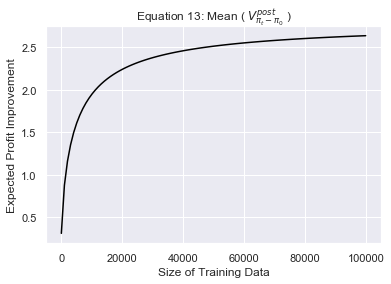

In [6]:
# Expected Profit Improvement vs. Size of Training Data (Equation 13 and Figure 1)

ntr_set = np.linspace(0,N_MAX,100,endpoint=True)

perf_mean = stats_g_prob_d_expected_improvement(0,0.5,mu_c,sigma_c,s_c,w_c,ntr_set,0)[1]

plt.plot(ntr_set,perf_mean,c='black',label=f"Control")
plt.xlabel("Size of Training Data")
plt.title(r"Equation 13: Mean ( $V_{\pi_t - \pi_0}^{post}$ )")
plt.ylabel("Expected Profit Improvement")
plt.show()

In [7]:
perf_no_training = get_expected_perf(mu_c, sigma_c, s_c, w_c, 0)[0]
perf_limit = get_expected_perf_limit(mu_c, sigma_c, s_c, w_c)

print(r"Expected policy performance with no training data:  %.2f"%(perf_no_training))
print(r"Expected policy performance limit (Equation 15):  %.2f"%(perf_limit))

Expected policy performance with no training data:  0.31
Expected policy performance limit (Equation 15):  2.79


In [8]:
# Sample size calculation for the d-expected improvement

# Algorithm 1
sample_d_exp = solve_d_expected_improvement(DELTA,mu_c,sigma_c,s_c,w_c) 

print(f"Sample size for $%.2f-expected improvement\n\t Analytical Solution (exact):  %d"%(DELTA,sample_d_exp))

Sample size for $1.50-expected improvement
	 Analytical Solution (exact):  4068


### Section 3.5: Probable $\delta$-Expected Improvement

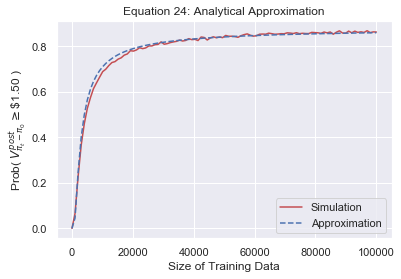

In [9]:
# Quality of the Analytical Approximation (Figure 2 in the paper)

ntr_set = np.linspace(0,N_MAX,100,endpoint=True)

prob_aprx,_ = stats_g_prob_d_expected_improvement(DELTA,GAMMA,mu_c,sigma_c,s_c,w_c,ntr_set,0)
prob_sim,_ = stats_g_prob_d_expected_improvement(DELTA,GAMMA,mu_c,sigma_c,s_c,w_c,ntr_set,B)

plt.plot(ntr_set,prob_sim,c='r',linestyle='solid',label=f"Simulation")
plt.plot(ntr_set,prob_aprx,c='b',linestyle='dashed',label=f"Approximation")

plt.xlabel("Size of Training Data")
plt.ylabel(r"Prob( $V_{\pi_t - \pi_0}^{post}\geq$\$%.2f )"%DELTA)
plt.title("Equation 24: Analytical Approximation")
plt.legend()
plt.show()

In [10]:
# Sample size calculation for the probable DELTA-expected improvement

# Algorithm 4
sample_g_prob_d_epx_sim = solve_g_prob_d_expected_improvement(
    DELTA,GAMMA,
    mu_c,sigma_c,s_c,w_c,
    N_MAX,N_PARAL,B)

print(f"Sample size for $%.2f-expected %.0f%%-probable improvement\n\t Simulation-based solution:  %d"%(DELTA,(1-GAMMA)*100,sample_g_prob_d_epx_sim))

# Algorithm 5
sample_g_prob_d_epx_approx = solve_g_prob_d_expected_improvement(
    DELTA,GAMMA,
    mu_c,sigma_c,s_c,w_c,
    N_MAX) 

print(f"\t Analytical approximation-based solution: %d"%(sample_g_prob_d_epx_approx))


Sample size for $1.50-expected 70%-probable improvement
	 Simulation-based solution:  10306
	 Analytical approximation-based solution: 9500


## Section 4: $(1-\alpha,1-\beta)$ Policy Certification

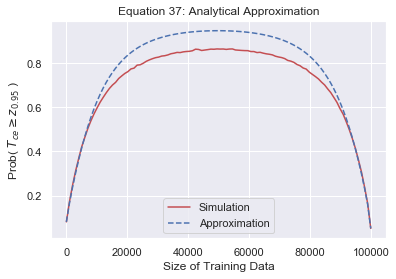

In [11]:
# Choose a reasonable BETA (for a given prior)

ntr_set = np.linspace(0,N_MAX-1,100)
power_set_aprx = []
power_set_sim = []
for ntr in ntr_set:
    power_set_aprx.append(get_prob_ab_cert_aprx(ntr, N_MAX-ntr, ALPHA, mu_c, sigma_c, s_c, w_c))
#     power_set_aprx.append(get_prob_ab_cert_aprx(ntr, N_MAX-ntr, ALPHA, mu_c, sigma_c, s_c, w_c,taylor=1))
    power_set_sim.append(get_prob_ab_cert_sim(ntr, N_MAX-ntr, ALPHA, mu_c, sigma_c, s_c, w_c, B))
    
plt.plot(ntr_set,power_set_sim,c='r',linestyle='solid',label=f"Simulation")
plt.plot(ntr_set,power_set_aprx,c='b',linestyle='dashed',label=f"Approximation")

plt.xlabel("Size of Training Data")
plt.ylabel(r"Prob( $T_{ce}\geq z_{%.2f}$ )"%(1-ALPHA))
plt.title("Equation 37: Analytical Approximation")
plt.legend()
plt.show()

100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


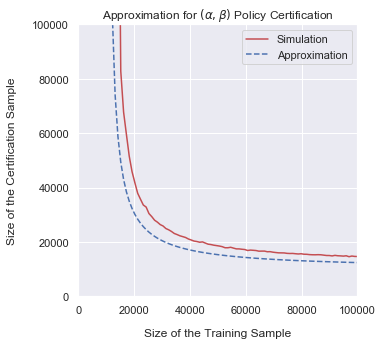

In [12]:
# Quality of the Analytical Approximation (Figure 5 in the paper)

ntr_set = np.linspace(0,N_MAX-1,100)

nce_set_aprx = solve_nce_aprx(ntr_set,ALPHA,BETA,mu_c,sigma_c,s_c,w_c)
# nce_set_aprx = np.zeros(len(ntr_set))
nce_set_sim = np.zeros(len(ntr_set))
for n in tqdm.tqdm(np.arange(len(ntr_set))):
#     nce_set_aprx[n] = solve_nce_taylor(ntr_set[n],N_MAX,ALPHA,BETA,mu_c,sigma_c,s_c,w_c)
    nce_set_sim[n] = solve_nce_sim(ntr_set[n],N_MAX,ALPHA,BETA,mu_c,sigma_c,s_c,w_c,B)
    
nce_set_aprx[nce_set_aprx<0] = N_MAX*2
nce_set_sim[nce_set_sim<0] = N_MAX*2

fig, ax = plt.subplots(figsize=(5,5))   

plt.plot(ntr_set,nce_set_sim,c='r',label=f"Simulation")
plt.plot(ntr_set,nce_set_aprx,c='b',linestyle='dashed',label=f"Approximation")

plt.xlabel("Size of the Training Sample", fontsize=12, labelpad=12)
plt.ylabel("Size of the Certification Sample", fontsize=12, labelpad=15)

plt.xlim([0,N_MAX])
plt.ylim([0,N_MAX])

plt.title(r"Approximation for $(\alpha,\beta)$ Policy Certification")
plt.legend()

plt.show()    

In [13]:
# Algorithm 3

ntr_aprx,nce_aprx = solve_ab_certification(ALPHA,BETA,mu_c,sigma_c,s_c,w_c,N_MAX)

In [14]:
ntr_taylor,nce_taylor = solve_ab_certification(ALPHA,BETA,mu_c,sigma_c,s_c,w_c,N_MAX,B=0,taylor=1)

100%|██████████| 100001/100001 [19:50<00:00, 83.97it/s] 


In [15]:
# Algorithm 2

ntr_sim,nce_sim = solve_ab_certification(ALPHA,BETA,mu_c,sigma_c,s_c,w_c,N_MAX,B)

100%|██████████| 100001/100001 [13:21<00:00, 124.76it/s]


In [16]:
print(f"Sample size for (a,b)-certification, confidence=%.0f%%, power=%.0f%%"%((1-ALPHA)*100,100*(1-BETA)))
print(f"\t Simulation-based solution: \t\t N_tr=%1.0f, N_ce=%1.0f, Total=%1.0f"%(ntr_sim,nce_sim,ntr_sim+nce_sim))
print(f"\t Analytical approximation (main): \t N_tr=%1.0f, N_ce=%1.0f, Total=%1.0f"%(ntr_aprx,nce_aprx,ntr_aprx+nce_aprx))
print(f"\t Analytical approximation (appendix): \t N_tr=%1.0f, N_ce=%1.0f, Total=%1.0f"%(ntr_taylor,nce_taylor,ntr_taylor+nce_taylor))


Sample size for (a,b)-certification, confidence=95%, power=70%
	 Simulation-based solution: 		 N_tr=29267, N_ce=25666, Total=54933
	 Analytical approximation (main): 	 N_tr=24103, N_ce=24668, Total=48771
	 Analytical approximation (appendix): 	 N_tr=27041, N_ce=27062, Total=54103
